In [1]:
import time
from dataloader import MinibooneLoader
from helpers import testAlgorithm, fitGridSearch
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Performance/Optimizations
EnableDaal4py = False    # Optimise sklearn for Intel CPUs (Requires daal4py)

verbose = 2
shuffleSeed = 0     # Data shuffle seed.
kFoldSeed = None    # Cross-validation shuffle seed.
targetCores = 7     # How many cores to use.
trainSize = 0.8
testSize = 0.2

# Set up a basic 5-fold cross-validation.
cv = KFold(n_splits=5, shuffle=True, random_state=kFoldSeed)

if (EnableDaal4py == True):
    from daal4py.sklearn import patch_sklearn
    patch_sklearn()

In [2]:
dataset = MinibooneLoader().loadMiniboone()

events = dataset.events

In [3]:
# Set up a preprocessing pipeline
estimators = [
    # Standardizes and scales the dataset
    ['scale', StandardScaler()]
]
pipe = Pipeline(estimators).fit(events)

# Transform the data using the prepared pipeline.
X = pipe.transform(events)
y = dataset.classifications

In [4]:

# Shuffle the dataset and split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=shuffleSeed, train_size=trainSize, test_size=testSize)

print('Data has been split. Training data:')
print(X_train)
print(y_train)

Data has been split. Training data:
[[ 0.04852549  0.05710245 -0.42166557 ...  0.04230077  0.08020339
   0.0614591 ]
 [ 0.08522973  0.05787857  0.40372423 ...  0.15819105  0.06338857
   0.0602966 ]
 [ 0.03886527  0.05797087 -0.56084576 ...  0.03024111  0.03142102
   0.06056402]
 ...
 [ 0.06007261  0.07552737  0.02669232 ...  0.06275209  0.08296288
   0.06197942]
 [ 0.06221417  0.06761905 -0.02986604 ...  0.07141983  0.07571434
   0.05977339]
 [ 0.06484492  0.0546634   0.00282108 ...  0.0365456   0.03887806
   0.0591355 ]]
[0 1 0 ... 1 1 1]


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:   38.2s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   38.7s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:   38.7s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:   38.8s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:   38.9s
[Parallel(n_jobs=7)]: Done   9 out of  20 | elapsed:   39.2s remaining:   47.9s
[Parallel(n_jobs=7)]: Done  11 out of  20 | elapsed:   57.9s remaining:   47.3s
[Parallel(n_jobs=7)]: Done  13 out of  20 | elapsed:  1.3min remaining:   40.7s
[Parallel(n_jobs=7)]: Done  15 out of  20 | elapsed:  1.3min remaining:   25.3s
[Parallel(n_jobs=7)]: Done  17 out of  20 | elapsed:  1.3min remaining:   13.5s
[Parallel(n_jobs=7)]: Done  20 out of  20 | elapsed:  1.5min finished



Best Score: 0.9343495163480317
Best Hyperparameters: {'epsilon': 1e-08, 'max_iter': 100}

Performance breakdown for each fit:
0.933 (+/-0.003) for {'epsilon': 1e-07, 'max_iter': 100}
0.930 (+/-0.003) for {'epsilon': 1e-07, 'max_iter': 50}
0.934 (+/-0.002) for {'epsilon': 1e-08, 'max_iter': 100}
0.931 (+/-0.002) for {'epsilon': 1e-08, 'max_iter': 50}

Total prediction time: 10.017578125ms
Average time/prediction: 0.00038509891688770997ms

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      7270
           1       0.96      0.95      0.95     18743

    accuracy                           0.93     26013
   macro avg       0.92      0.93      0.92     26013
weighted avg       0.94      0.93      0.94     26013


Confusion matrix:


/home/zachc/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


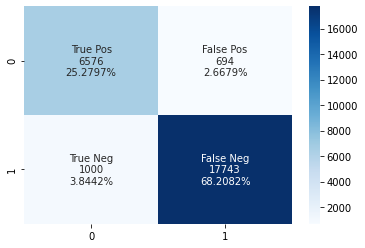

In [5]:
# Define our hyperameter grid-space.
parameters={
    'max_iter': ( 100, 50 ),
    'epsilon': (1e-7, 1e-8)
}

# Define our estimator
mlp=MLPClassifier(hidden_layer_sizes=(25, 25))
# Set up the final grid-search
search = GridSearchCV(estimator=mlp, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=20)

fitGridSearch(search, X_train, y_train)
testAlgorithm(search, X_test, y_test)

In [6]:
# Define our hyperameter grid-space.
parameters={
    'hidden_layer_sizes': (
        # (10, 10, 10),
        (5, 5, 5),
        (25, 25),
        # (10, 10),
        (5, 5),
        (25)
    ),
    'max_iter': ( 500, 250, 100 ),
    'activation': ( 'tanh', 'relu' ),
    'n_iter_no_change': ( 10, 20 ),
    'epsilon': (1e-7, 1e-8)
}

# Define our estimator
mlp=MLPClassifier()
# Set up the final grid-search
nn_search = GridSearchCV(estimator=mlp, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=verbose)

fitGridSearch(nn_search, X_train, y_train)
testAlgorithm(nn_search, X_test, y_test)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  4.7min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 26.0min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 60.7min
[Parallel(n_jobs=7)]: Done 480 out of 480 | elapsed: 79.3min finished



Best Score: 0.9384340555122185
Best Hyperparameters: {'activation': 'tanh', 'epsilon': 1e-08, 'hidden_layer_sizes': (25, 25), 'max_iter': 500, 'n_iter_no_change': 20}

Performance breakdown for each fit:
0.927 (+/-0.005) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 500, 'n_iter_no_change': 10}
0.930 (+/-0.005) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 500, 'n_iter_no_change': 20}
0.927 (+/-0.003) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 250, 'n_iter_no_change': 10}
0.929 (+/-0.001) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 250, 'n_iter_no_change': 20}
0.922 (+/-0.006) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 100, 'n_iter_no_change': 10}
0.923 (+/-0.005) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 100, 'n_

In [7]:
# NOTE: loss not set to hinge. Causes NaN accuracy and doesn't run.
# Define our hyperameter grid-space.
parameters={
    'penalty': ('l1', 'l2'),
    'dual': (True, False),
    'tol': (1e-4, 1e-5, 5e-5),
    'class_weight': (None, 'balanced'),
    'max_iter': (1000, 2000, 500, 250, 100)
}

# Define our SVM. LinearSVC is used in this case since it is more optimized for larger datasets than SVC.
svm=LinearSVC()
# Set up the final grid-search
svm_search = GridSearchCV(estimator=svm, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=verbose)

fitGridSearch(svm_search, X_train, y_train)
testAlgorithm(svm_search, X_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  5.2min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 27.1min
[Parallel(n_jobs=7)]: Done 600 out of 600 | elapsed: 46.4min finished



Best Score: 0.9011734520780615
Best Hyperparameters: {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l2', 'tol': 5e-05}

Performance breakdown for each fit:
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l1', 'tol': 5e-05}
0.900 (+/-0.006) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}
0.901 (+/-0.002) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l2', 'tol': 1e-05}
0.901 (+/-0.002) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l2', 'tol': 5e-05}
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 2000, 'penalty': 'l1', 'tol': 0.0001}
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 2000, 'penalty': 'l1'

/home/zachc/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [8]:
# Perform grid search to identify the best hyperparameters

# NOTE: loss not set to hinge. Causes NaN accuracy and doesn't run.
# Define our hyperameter grid-space.
parameters={
    'n_estimators': (10, 100, 250),
    'criterion': ('gini', 'entropy'),
    'min_samples_split': (2, 5),
    'min_samples_leaf': (2, 5),
    'class_weight': ('balanced', 'balanced_subsample', None),
    'max_features': ('auto', 'log2'),
    'oob_score': (False, True)
}

# Define our Random forest classifier.
rf=RandomForestClassifier()
# Set up the final grid-search
rf_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=verbose)

fitGridSearch(rf_search, X_train, y_train)
testAlgorithm(rf_search, X_test, y_test)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 29.3min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 67.0min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed: 116.9min
[Parallel(n_jobs=7)]: Done 999 tasks      | elapsed: 184.2min
[Parallel(n_jobs=7)]: Done 1440 out of 1440 | elapsed: 270.4min finished



Best Score: 0.9375979098031341
Best Hyperparameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 250, 'oob_score': True}

Performance breakdown for each fit:
0.927 (+/-0.002) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': False}
0.927 (+/-0.004) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.936 (+/-0.002) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False}
0.936 (+/-0.001) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.936 (

Confusion matrix for MLP


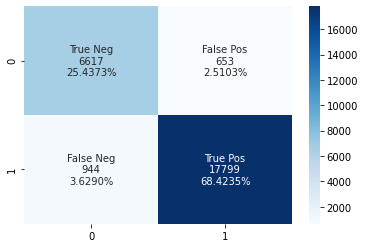

Confusion matrix for SVM


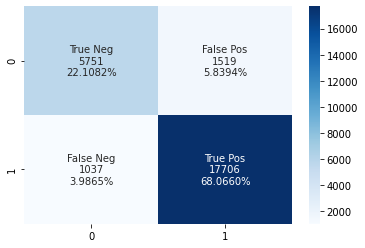

Confusion matrix for RF


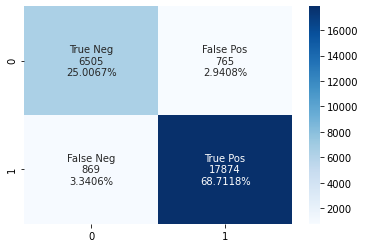